Fait :
- Baselines: Naive Bayes, Logistic Regression, SVM, Boosting, Random Forest
- Classifieur binaire MLP et Conv1D
- Classifieur multilabel Conv1D
- Classifier GRU + Conv1D
- Classifier Fast Text
- Classifier LSTM et LSTM + Attention
- Classifier RCNN
- Petit test de Transformers
- Tenter une segmentation au niveau des caractères, car beaucoup de commentaire contiennent des mots du style "fu cky ou" ou "dickfuck" ou je ne sais quel autre poésie (ça marche moins bien)
- J'ai mis une longueur maximum de 1000 mots par commentaires, pour accélerer le processus, car de toute façon quand y a + de 1000 mots en général c'est juste un copié collé à la suite avec des insultes
- Ajouter la possibilité d'utiliser les embeddings préentrainés de Glove Twitter (attention ça prends du temps à download)
- Détecteur de biais sur les minorités
- Léger pre-processing des commentaires (qui ne semble pas apporter grand chose)
- Modifié le balancing au niveau de la génération des batches 
- Essayé les modèles bi-directionnels
- Essayé d'ajouter quelques métriques + significatives que l'accuracy (AUC, F1 Score)

A faire :


- Ajouter 'seq_length' dans les x_data
- Se mettre à utiliser des LSTM ou GRU à un moment puis bi LSTM

# 1. Some imports


In [0]:
from argparse import Namespace
from collections import Counter
import json
import re
import string
import os
import sys
import nltk 
import re

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, PackedSequence
from torch.distributions import Bernoulli
from torch.autograd import Variable
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams


from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
nltk.download('stopwords')
sys.setrecursionlimit(10000)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
!pip install transformers
!pip install tensorboardx
!pip install simpletransformers

     |████████████████████████████████| 645kB 2.8MB/s 
     |████████████████████████████████| 3.8MB 36.1MB/s 
     |████████████████████████████████| 1.1MB 33.6MB/s 
     |████████████████████████████████| 890kB 42.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=90c9c607c719af1a7774d184716b23d532fd0bede9dac6cbf9d52a0f6bece47e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 204kB 2.7MB/s 
     |████████████████████████████████| 194kB 2.8MB/s 
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=b1940b0d9d3620667a8d954a43b3598922b7dd1e115dde100fc2ee4bdfc87b76
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


In [0]:
!git clone https://github.com/NVIDIA/apex
%cd apex
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

Cloning into 'apex'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 6750 (delta 0), reused 1 (delta 0), pack-reused 6742
Receiving objects: 100% (6750/6750), 13.74 MiB | 27.59 MiB/s, done.
Resolving deltas: 100% (4505/4505), done.
/content/apex
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-j3uug_ny
Created temporary directory: /tmp/pip-req-tracker-kfqavovz
Created requirements tracker '/tmp/pip-req-tracker-kfqavovz'
Created temporary directory: /tmp/pip-install-o57_qj5a
Processing /content/apex
  Created temporary directory: /tmp/pip-req-build-fj9wbr5v
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-kfqavovz'
    Running s

In [0]:
!wget http://theo.delemazure.fr/perso/toxic_comments.csv
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip

--2020-05-13 13:00:41--  http://theo.delemazure.fr/perso/toxic_comments.csv
Resolving theo.delemazure.fr (theo.delemazure.fr)... 217.160.0.80, 2001:8d8:100f:f000::267
Connecting to theo.delemazure.fr (theo.delemazure.fr)|217.160.0.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65817304 (63M) [text/csv]
Saving to: ‘toxic_comments.csv’

toxic_comments.csv  100%[===================>]  62.77M  6.72MB/s    in 9.9s    

2020-05-13 13:00:51 (6.35 MB/s) - ‘toxic_comments.csv’ saved [65817304/65817304]

--2020-05-13 13:00:52--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2020-05-13 13:00:52--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)

In [0]:
from simpletransformers.classification import ClassificationModel
from simpletransformers.classification import MultiLabelClassificationModel

## 1.a. Playing with data

In [0]:
sns.set()
data = pd.read_csv('toxic_comments.csv')
for index, row in data.iterrows():
  if row.clean and (row.toxic == 1 or row.identity_hate == 1 or row.insult == 1 or row.obscene == 1 or row.severe_toxic == 1 or row.threat == 1):
    print(row)
#print(data[data.clean == True and data.toxic == 1])

In [0]:
data.head()

,clean,comment_text,identity_hate,insult,obscene,severe_toxic,split,threat,toxic
0,False,i am only going to fucking say this once those...,0,0,1,0,train,0,1
1,False,2010 's arthur rubin i want to thank but i lik...,0,1,1,0,train,0,1
2,False,anonymous you gay afambro fuck you,1,1,1,0,train,0,1
3,False,putting stupid comments in articles will resul...,0,0,0,0,train,0,1
4,False,boobies tatas taters hooters funbags tits hoot...,0,0,1,0,train,0,1


In [0]:
lcom = []
for com in data["comment_text"]:
  lcom.append((len(com.split(" ")), com))

lcom = sorted(lcom)[::-1]

for i in range(50):
  print(lcom[i][0], lcom[i][1])

4949 you ! you blocked me worm why ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !

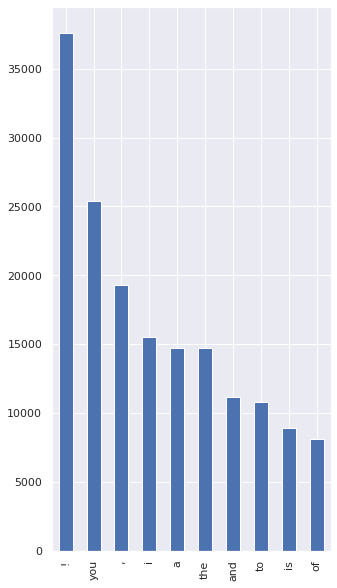

In [0]:
train = data[data.split == "train"].copy()
train['length'] = train['comment_text'].apply(len)
toxic_data = train[train['toxic'] == 1]
sevtoxic_data = train[train['severe_toxic'] == 1]
nontoxic=train[train.iloc[:,2:7].sum(axis=1)==0]

count=pd.Series(' '.join(toxic_data['comment_text']).split()).value_counts()
count=count.sort_values(ascending=False)
count_head=count.head(10)
count_head.plot(kind = 'bar', figsize=(5,10))

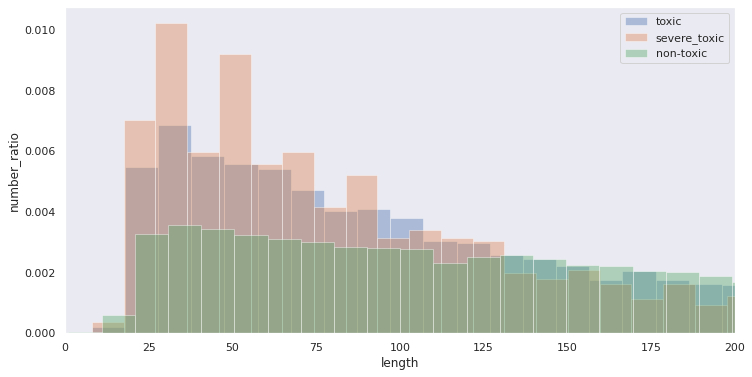

In [0]:
rcParams['figure.figsize'] = (12.0, 6.0)
bins = 1000
plt.hist(toxic_data['length'], alpha = 0.4, bins=bins, label='toxic',density=True)
plt.hist(sevtoxic_data['length'], alpha = 0.4, bins=bins, label='severe_toxic',density=True)
plt.hist(nontoxic['length'], alpha = 0.4, bins=bins, label='non-toxic',density=True)
plt.xlabel('length')
plt.ylabel('number_ratio')
plt.legend(loc='upper right')
plt.xlim(0,200)
plt.grid()
plt.show()

clean            100336.0
toxic             10719.0
insult             5521.0
obscene            5904.0
severe_toxic       1112.0
identity_hate       996.0
threat              340.0
dtype: float64


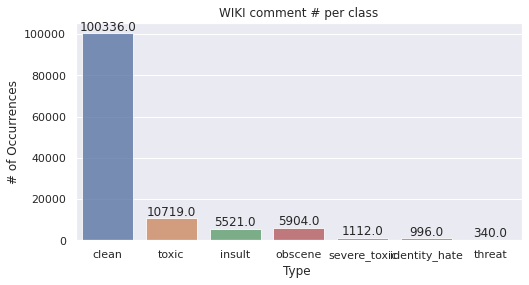

ratio of wiki toxic comment 0.22017494381921876


In [0]:
#x=train.iloc[:,2:7].sum()
nb_occ = train[["clean", "toxic", "insult", "obscene", "severe_toxic", "identity_hate", "threat"]].sum()
#plot
plt.figure(figsize=(8,4))
print(nb_occ)
ax= sns.barplot(nb_occ.index, nb_occ.values, alpha=0.8)
plt.title("WIKI comment # per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = nb_occ.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()
print('ratio of wiki toxic comment', nb_occ[["toxic", "insult", "obscene", "severe_toxic", "identity_hate", "threat"]].sum()/len(train))

# 2. Vocabulary

La classe "Vocabulary" créé un dictionnaire qui associe à chaque mot du vocabulaire un entier (son index). Elle contient des fonctions pour aller du mot vers son index et inversement.

In [0]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)


La classe "SequenceVocabulary" hérite de la classe vocabulary et permets de définir des token pour les débuts de phrase, fin de phrase, mot inconnu et "mask" pour après la fin de la phrase (si les phrase d'un minibatch sont de longueur différente)

In [0]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

# 3. The Vectorizer

Le vectorizer permet de transformer un commentaire en un suite de token (leur index  + les tokens spéciaux)

## 3.a. Word level

In [0]:
class CommentVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""    
    def __init__(self, comment_vocab, bigrams=False):
        self.comment_vocab = comment_vocab
        self.bigrams = bigrams
    def vectorize(self, comment, vector_length=-1):
        """
        Args:
            comment (str): the string of words separated by a space
            vector_length (int): an argument for forcing the length of index vector
        Returns:
            the vetorized comment (numpy.array)
        """

        # Added bigrams
        indices = [self.comment_vocab.begin_seq_index]
        tokens = comment.split(" ")
        if args.bigrams:
            tokens = generate_bigrams(tokens)
        indices.extend(self.comment_vocab.lookup_token(token) 
                       for token in tokens)
        indices.append(self.comment_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices[:vector_length]
        out_vector[len(indices):] = self.comment_vocab.mask_index

        return out_vector

    @classmethod
    def from_dataframe(cls, comments_df, cutoff=5, bigrams=False):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            comments_df (pandas.DataFrame): the target dataset
            cutoff (int): frequency threshold for including in Vocabulary 
        Returns:
            an instance of the NewsVectorizer
        """
        
        # Bigrams
        word_counts = Counter()
        for comment in comments_df.comment_text:
            tokens = comment.split(" ")
            if args.bigrams:
              tokens = generate_bigrams(tokens)
            for token in tokens:
                if token not in string.punctuation:
                    word_counts[token] += 1
        
        comment_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                comment_vocab.add_token(word)
        
        return cls(comment_vocab)

    @classmethod
    def from_serializable(cls, contents):
        comment_vocab = \
            SequenceVocabulary.from_serializable(contents['comment_vocab'])

        return cls(comment_vocab=comment_vocab)

    def to_serializable(self):
        return {'comment_vocab': self.comment_vocab.to_serializable()}

## 3.b. char level

Voici une deuxième classe de vectorizer, pour séparer plus finement, au niveau des caractères

In [0]:
class CommentVectorizerChar(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, comment_vocab, max_comment_length):
        """
        Args:
            surname_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
            max_surname_length (int): the length of the longest surname
        """
        self.comment_vocab = comment_vocab
        self._max_comment_length = max_comment_length

    def vectorize(self, comment, vector_length=-1):
        """
        Args:
            comment (str): the comment
        Returns:
            one_hot_matrix (np.ndarray): a matrix of one-hot vectors
        """
        indices = [self.comment_vocab.begin_seq_index]
        indices.extend(self.comment_vocab.lookup_token(token) 
                       for token in comment)
        indices.append(self.comment_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices[:vector_length]
        out_vector[len(indices):] = self.comment_vocab.mask_index

        return out_vector

    @classmethod
    def from_dataframe(cls, comments_df,cutoff=5):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            comments_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        max_comment_length = 0

        char_count = Counter()
        for comment in comments_df.comment_text:
          max_comment_length = max(max_comment_length,len(comment))
          for token in comment:
            # Modified this
            if token not in string.punctuation and token not in stopword:
              char_count[token] += 1
        
        comment_vocab = SequenceVocabulary()
        for char, char_c in char_count.items():
            if char_c >= cutoff:
                comment_vocab.add_token(char)

        return cls(comment_vocab,  max_comment_length)

    @classmethod
    def from_serializable(cls, contents):
        comment_vocab = Vocabulary.from_serializable(contents['comment_vocab'])
        return cls(comment_vocab=comment_vocab,  
                   max_comment_length=contents['max_comment_length'])

    def to_serializable(self):
        return {'comment_vocab': self.comment_vocab.to_serializable(),
                'max_comment_length': self._max_comment_length}

# 4. The Dataset

Cette classe permet d'accéder facilement aux commentaires du dataset

J'ai rajouté un paramètre "balanced". Ce paramètre permets de choisir si on veut un dataset avec 50% Good et 50% Bad (True) ou 90% Good et 10% Bad (False). Les deux ont autant de commentaires labelisé "Good".



In [0]:
class CommentDataset(Dataset):
    def __init__(self, comments_df, vectorizer,
                 balanced=False,binary=True,fine_grained=False,
                 max_length=-1,length_out=False, preprocess=False):
        """
        Args:
            comments_df (pandas.DataFrame): the dataset
            vectorizer (CommentsVectorizer): vectorizer instatiated from dataset
        """
        self.comments_df = comments_df.copy()   # Je le modifie plus tard. Juste pour eviter un effet de bord.
        if preprocess:
          self.comments_df['comment_text'] = self.comments_df['comment_text'].apply(lambda txt: clean_text(txt, tokenize=False)) 
        self._vectorizer = vectorizer
        self._binary = binary
        self._length_out = length_out
        # +1 if only using begin_seq, +2 if using both begin and end seq tokens
        if binary:
          self._n_classes = 2
        else:
          self._n_classes = 7  # 6 or 7 ?
        if fine_grained:
          self.measure_len = lambda context: len(context)
        else:
          self.measure_len = lambda context: len(context.split(" "))

        if max_length == -1:
          self._max_seq_length = max(map(self.measure_len, comments_df.comment_text)) + 2
        else:
          self._max_seq_length = max_length +2
        

        self.train_df = self.comments_df[self.comments_df.split=='train']
        self.train_size = len(self.train_df)

        if balanced:
          self.samples_weights = np.zeros(self.train_size) 
          if binary:
            self.samples_weights[self.train_df.clean == True] = 1. / 6. # 1. / self.train_df.loc[self.train_df.clean == True].shape[0] pour 50-50
            self.samples_weights[self.train_df.clean == False] = 1. # 1. / self.train_df.loc[self.train_df.clean == False].shape[0] pour 50-50
          else:
            # This one is tricky. How to balance the multi-class case ?
            self.samples_weights[self.train_df.clean == True] = 1. / 6. 
            self.samples_weights[self.train_df.clean == False] = 1. 

        
        self.val_df = self.comments_df[self.comments_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.comments_df[self.comments_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        """
        class_counts = comments_df.clean.value_counts().to_dict()

        def sort_key(item):
            return self._vectorizer.category_vocab.lookup_token(item[0])
        
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
        """
        
        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, comments_csv,balanced=False,
                                         binary=True,fine_grained=False,
                                         max_length=-1,length_out=False, preprocess=False):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        comments_df = pd.read_csv(comments_csv)
        train_comments_df = comments_df[comments_df.split=='train']
        if fine_grained:
          comment_vectorizer = CommentVectorizerChar.from_dataframe(train_comments_df)
        else:
          comment_vectorizer = CommentVectorizer.from_dataframe(train_comments_df)
        return cls(comments_df,comment_vectorizer ,
                   balanced,binary,fine_grained,
                   max_length, length_out, preprocess)

    @classmethod
    def load_dataset_and_load_vectorizer(cls, news_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            surname_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of SurnameDataset
        """
        comments_df = pd.read_csv(comments_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(comments_csv, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of SurnameVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return NameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]
        
        vect_length = min(self.measure_len(row.comment_text)+1,self._max_seq_length-1)

        comments_vector = \
            self._vectorizer.vectorize(row.comment_text, self._max_seq_length)

        if self._length_out:
          comments_vector = np.concatenate([[vect_length], comments_vector])
        
        if row.clean:
          category_index = 0.0
        else:
          category_index = 1.0

        if self._binary:
          target = category_index
        else:
          target = torch.tensor([category_index,
                                 row.identity_hate,
                                 row.insult,
                                 row.obscene,
                                 row.severe_toxic,
                                 row.threat,
                                 row.toxic])
        return {'x_data': comments_vector,
                'y_target': target}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size



## 4.a. batch generator

Ci-dessous une fonction pour génerer automatiquement des batchs lors de la phase d'entrainement

In [0]:
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu", balanced=False): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    if balanced:
      sampler = WeightedRandomSampler(
      weights=dataset.samples_weights,
      num_samples=dataset.train_size,
      replacement=True)
      dataloader = DataLoader(dataset=dataset, batch_size=batch_size, sampler=sampler,
                            drop_last=drop_last)
    else:
      dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict
        torch.cuda.empty_cache()


In [0]:
def generate_batches_sorted(dataset, batch_size, shuffle=True, 
                            drop_last=True, device="cpu"):
    """A generator function which wraps the PyTorch DataLoader.  The NMT Version """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        lengths = data_dict['x_data'][:,0].numpy()
        sorted_length_indices = lengths.argsort()[::-1].tolist()
        
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name][sorted_length_indices].to(device)
        yield out_data_dict

# 5. Helping functions

Ces fonctions permettent de mettre à jour l'état d'entrainement qui sauvegarde les loss et accuracy à chaque epoch pour le train et le val dataset (entre autre)

In [0]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [0]:
stopword = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

def clean_text(text, tokenize=True, lemmatize=False):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    if tokenize:
      tokens = re.split('\W+', text_rc)    # tokenization
      if lemmatize:
        text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
      else:
        text = [word for word in tokens if word not in stopword] # remove stopwords
    return text

In [0]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [0]:
def make_embedding_matrix(glove_filepath, words):
    """
    Create embedding matrix for a specific set of words.
    
    Args:
        glove_filepath (str): file path to the glove embeddigns
        words (list): list of words in the dataset
    """
    word_to_idx, glove_embeddings = load_glove_from_file(glove_filepath)
    embedding_size = glove_embeddings.shape[1]
    
    final_embeddings = np.zeros((len(words), embedding_size))

    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = glove_embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i

    return final_embeddings

In [0]:
def load_glove_from_file(glove_filepath):
    """
    Load the GloVe embeddings 
    
    Args:
        glove_filepath (str): path to the glove embeddings file 
    Returns:
        word_to_index (dict), embeddings (numpy.ndarary)
    """

    word_to_index = {}
    embeddings = []
    with open(glove_filepath, "r") as fp:
        for index, line in enumerate(fp):
            line = line.split(" ") # each line: word num1 num2 ...
            word_to_index[line[0]] = index # word = line[0] 
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)
    return word_to_index, np.stack(embeddings)

La fonction ci-dessous permets de calculer une accuracy, dans le cas ou il y a une seule output

In [0]:
def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu().long()#.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

Fonction pour la generation des bi-grams

In [0]:
def generate_bigrams(x):
    n_grams = set(zip(*[x[i:] for i in range(2)]))
    for n_gram in n_grams:
        x.append(' '.join(n_gram))
    return x

# 6. Models

## 6.a. Multi Layer Perceptron

Ci-dessous un premier modèle (MultiLayerPerceptron)

+ 10 epochs, emb 50,hid 50, bs128,do0.15,lr-3 : 87%
+ idem + glove : 89%

In [0]:
class MLPClassifier(nn.Module):
    """ a simple perceptron based classifier """
    def __init__(self, embedding_size, num_embeddings, 
                 hidden_dim, dropout_p, out_dim,
                 pretrained_embeddings=None,length_out=False,
                 padding_idx=0):
        """
        Args:
            embedding_size (int): size of the embedding vectors
            num_embeddings (int): number of embedding vectors
            filter_width (int): width of the convolutional kernels
            num_channels (int): number of convolutional kernels per layer
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained word embeddings
                default is None. If provided, 
            padding_idx (int): an index representing a null position
        """
        
        super(MLPClassifier, self).__init__()

        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
        
            
        

        self._dropout_p = dropout_p
        self._length_out = length_out
        self.fc1 = nn.Linear(embedding_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x_in, apply_sigmoid=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, num_features)
            apply_sigmoid (bool): a flag for the sigmoid activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch,)
        """
        if self._length_out:
          x_in = x_in[:,1:]
          
        x_embedded = self.emb(x_in)

        features = x_embedded.sum(dim=1)
        #features = F.dropout(features, p=self._dropout_p)
        
        # mlp classifier
        intermediate_vector = F.relu(F.dropout(self.fc1(features), p=self._dropout_p))
        prediction = self.fc2(intermediate_vector).squeeze()

        if apply_sigmoid:
            prediction = F.sigmoid(prediction)

        return prediction

## 6.b. Conv 1D

Le classifieur CNN suivant à l'air d'overfitté au fil des époques, cependant, il atteint 95% d'accuracy mais surtout 81% sur les commentaires "méchants"

+ 20 epochs, emb 50,hid 50, 128chqnm bs128,do0.15,lr-3 : 90%
+ idem + glove : 92%

In [0]:
class CNNClassifier(nn.Module):
    """ a simple perceptron based classifier """
    def __init__(self, embedding_size, num_embeddings, 
                 num_channels, hidden_dim, dropout_p, out_dim,
                 pretrained_embeddings=None,length_out=False,
                 padding_idx=0,kernel_size=3):
        """
        Args:
            embedding_size (int): size of the embedding vectors
            num_embeddings (int): number of embedding vectors
            filter_width (int): width of the convolutional kernels
            num_channels (int): number of convolutional kernels per layer
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained word embeddings
                default is None. If provided, 
            padding_idx (int): an index representing a null position
        """
        
        super(CNNClassifier, self).__init__()

        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
        
        self.convnet = nn.Sequential(
            nn.Conv1d(in_channels=embedding_size, 
                   out_channels=num_channels, kernel_size=3),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                   kernel_size=kernel_size, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                   kernel_size=kernel_size, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                   kernel_size=kernel_size),
            nn.ELU()
        )

        self._dropout_p = dropout_p
        self._length_out = length_out
        self.fc1 = nn.Linear(num_channels, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)


    def forward(self, x_in, apply_sigmoid=False):
        """The forward pass of the classifier
        
        Args:
            x_surname (torch.Tensor): an input data tensor. 
                x_surname.shape should be (batch, initial_num_channels, max_surname_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        if self._length_out:
          x_in = x_in[:,1:]

        x_embedded = self.emb(x_in).permute(0, 2, 1)
        
        features = self.convnet(x_embedded)

        # average and remove the extra dimension
        remaining_size = features.size(dim=2)
        features = F.avg_pool1d(features, remaining_size).squeeze(dim=2)
        features = F.dropout(features, p=self._dropout_p)
        
        # mlp classifier
        intermediate_vector = F.relu(F.dropout(self.fc1(features), p=self._dropout_p))
        prediction = self.fc2(intermediate_vector).squeeze()

        if apply_sigmoid:
            prediction = F.sigmoid(prediction)

        return prediction

## 6.c. Fast Text

Modèle inspiré du papier https://arxiv.org/abs/1607.01759 
En gros, c'est juste un MLP avec une phase de pre-processing du texte où on ajoute à la fin de chaque phrase les n-grams qui y apparaissent (bigrams ici)

In [0]:
class FastText(nn.Module):
    def __init__(self, num_embeddings, embedding_size, hidden_dim, out_dim, padding_idx, length_out=False, pretrained_embeddings=None, dropout_p=0.0):
        
        super().__init__()
        
        self._length_out = length_out
        self._dropout_p = dropout_p

        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)

        
        self.fc1 = nn.Linear(embedding_size, hidden_dim)

        self.fc2 = nn.Linear(hidden_dim, out_dim)
        
    def forward(self, x, apply_sigmoid=False):
        
        x_in = x.t()
        if self._length_out:
          x_in = x_in[1:, :]
          
        embedded = self.emb(x_in)                
        
        embedded = embedded.permute(1, 0, 2)
                
        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1) 
        prediction = F.relu(F.dropout(self.fc1(pooled), p=self._dropout_p))
        prediction = self.fc2(prediction).squeeze()

        if apply_sigmoid:
            prediction = F.sigmoid(prediction)

        return prediction

## 6.d. GRU + Conv1D sur les variables d'état

90% Pour le classifieur suivant avec une courbe de loss bizarre mais 90% sur les mauvais commentaires !

In [0]:
class GRUClassifier(nn.Module):
    """ a simple perceptron based classifier """
    def __init__(self, embedding_size, num_embeddings, 
                 rnn_hidden_size,num_channels, hidden_dim, dropout_p, out_dim,
                 pretrained_embeddings=None, length_out=False,
                 padding_idx=0,kernel_size=3):
        """
        Args:
            embedding_size (int): size of the embedding vectors
            num_embeddings (int): number of embedding vectors
            filter_width (int): width of the convolutional kernels
            num_channels (int): number of convolutional kernels per layer
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained word embeddings
                default is None. If provided, 
            padding_idx (int): an index representing a null position
        """
        
        super(GRUClassifier, self).__init__()

        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
        
        self.rnn = nn.GRU(input_size=embedding_size, 
                          hidden_size=rnn_hidden_size,
                          batch_first=True,
                          bidirectional=True)
        
        self.convnet = nn.Sequential(
            nn.Conv1d(in_channels=rnn_hidden_size*2, 
                   out_channels=num_channels, kernel_size=3),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                   kernel_size=kernel_size, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                   kernel_size=kernel_size),
            nn.ELU()
        )
        self._dropout_p = dropout_p
        self._length_out = length_out
        self.fc1 = nn.Linear(num_channels, out_dim)


    def forward(self, x_in, apply_sigmoid=False):
        """The forward pass of the classifier
        
        Args:
            x_surname (torch.Tensor): an input data tensor. 
                x_surname.shape should be (batch, initial_num_channels, max_surname_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        if self._length_out:
          x_in = x_in[:,1:]
          
        x_embedded = self.emb(x_in)

        y_out, _ = self.rnn(x_embedded)
        y_out = y_out.permute(0, 2, 1)
        features = self.convnet(y_out)
        # average and remove the extra dimension
        remaining_size = features.size(dim=2)

        features = F.avg_pool1d(features, remaining_size).squeeze(dim=2)
        features = F.dropout(features, p=self._dropout_p)

        prediction = self.fc1(F.dropout(features, p=self._dropout_p)).squeeze()
        if apply_sigmoid:
            prediction = F.sigmoid(prediction)

        return prediction

## 6.e. GRU + MLP sur les variable d'état finales

In [0]:
class GRUClassifier2(nn.Module):
    """ a simple perceptron based classifier """
    def __init__(self, embedding_size, num_embeddings, 
                 rnn_hidden_size, hidden_dim, dropout_p, out_dim,
                 pretrained_embeddings=None, padding_idx=0,kernel_size=3):
        """
        Args:
            embedding_size (int): size of the embedding vectors
            num_embeddings (int): number of embedding vectors
            filter_width (int): width of the convolutional kernels
            num_channels (int): number of convolutional kernels per layer
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained word embeddings
                default is None. If provided, 
            padding_idx (int): an index representing a null position
        """
        
        super(GRUClassifier2, self).__init__()

        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
        
        self.rnn = nn.GRU(input_size=embedding_size, 
                          hidden_size=rnn_hidden_size,
                          batch_first=True,
                          bidirectional=False)
        
        self._dropout_p = dropout_p
        self.fc1 = nn.Linear(rnn_hidden_size, out_dim)


    def forward(self, x_in, apply_sigmoid=False):
        """The forward pass of the classifier
        
        Args:
            x_surname (torch.Tensor): an input data tensor. 
                x_surname.shape should be (batch, initial_num_channels, max_surname_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        batchsize,seq_length = x_in.size()
        x_length = x_in[:, 0]

        x_in = x_in[:, 1:]

        x_embedded = self.emb(x_in)

        y_out, _ = self.rnn(x_embedded)

        features = []
        for i in range(batchsize):
          features.append(y_out[i,x_length[i],:])

        features = torch.stack(features)

        prediction = self.fc1(F.dropout(features, p=self._dropout_p)).squeeze()
        
        if apply_sigmoid:
            prediction = F.sigmoid(prediction)

        return prediction

## 6.f. LSTM + MLP sur les variable d'état finales

In [0]:
class LSTMClassifier(nn.Module):
    """ a simple perceptron based classifier """
    def __init__(self, embedding_size, num_embeddings, 
                 rnn_hidden_size, hidden_dim, dropout_p, out_dim,
                 pretrained_embeddings=None, padding_idx=0, 
                 kernel_size=3, dropout_rec=0.1, bidirectional=True, n_layers=1):
        """
        Args:
            embedding_size (int): size of the embedding vectors
            num_embeddings (int): number of embedding vectors
            filter_width (int): width of the convolutional kernels
            num_channels (int): number of convolutional kernels per layer
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained word embeddings
                default is None. If provided, 
            padding_idx (int): an index representing a null position
        """
        
        super(LSTMClassifier, self).__init__()

        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
        
        self.rnn = nn.LSTM(input_size=embedding_size, 
                          hidden_size=rnn_hidden_size,
                          num_layers=n_layers, 
                          dropout=dropout_rec,
                          batch_first=True,
                          bidirectional=bidirectional)
        
        self._dropout_p = dropout_p

        if bidirectional:
          self.fc1 = nn.Linear(2 * rnn_hidden_size, hidden_dim)
        else:
          self.fc1 = nn.Linear(rnn_hidden_size, hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, out_dim)



    def forward(self, x_in, apply_sigmoid=False):
        """The forward pass of the classifier
        
        Args:
            x_surname (torch.Tensor): an input data tensor. 
                x_surname.shape should be (batch, initial_num_channels, max_surname_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        batchsize,seq_length = x_in.size()
        x_length = x_in[:,0]

        x_in = x_in[:,1:]

        x_embedded = self.emb(x_in)

        y_out, _ = self.rnn(x_embedded)

        features = []
        for i in range(batchsize):
          features.append(y_out[i,x_length[i],:])

        features = torch.stack(features)

        intermediate_vector = self.fc1(F.dropout(features, p=self._dropout_p))
        prediction = self.fc2(F.dropout(intermediate_vector, p=self._dropout_p)).squeeze()
        
        if apply_sigmoid:
            prediction = F.sigmoid(prediction)

        return prediction

##6.g. LSTM with Attention 

In [0]:
class LSTMAttentionClassifier(torch.nn.Module):
  def __init__(self, embedding_size, num_embeddings, out_dim, rnn_hidden_size, pretrained_embeddings=None, padding_idx=0, dropout_rec=0.1, bidirectional=False, n_layers=1):
    super(LSTMAttentionClassifier, self).__init__()
    if pretrained_embeddings is None:
      self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
    else:
      pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
      self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)	
    
    self.lstm = nn.LSTM(input_size=embedding_size, 
                        hidden_size=rnn_hidden_size,
                        num_layers=n_layers, 
                        dropout=dropout_rec,
                        batch_first=True,
                        bidirectional=bidirectional)
  

    if bidirectional:
        self.fc = nn.Linear(2 * rnn_hidden_size, out_dim)
    else:
        self.fc = nn.Linear(rnn_hidden_size, out_dim)
		
  def attention_net(self, lstm_output, final_state):
    """ 
		Arguments
		---------
		
		lstm_output : Final output of the LSTM which contains hidden layer outputs for each sequence.
		final_state : Final time-step hidden state (h_n) of the LSTM
		
		---------
		
		Returns : It performs attention mechanism by first computing weights for each of the sequence present in lstm_output and and then finally computing the
				  new hidden state.
				  
		Tensor Size :
					hidden.size() = (batch_size, hidden_size)
					attn_weights.size() = (batch_size, num_seq)
					soft_attn_weights.size() = (batch_size, num_seq)
					new_hidden_state.size() = (batch_size, hidden_size)
					  
		"""


    hidden = final_state.squeeze(0)
    attn_weights = torch.bmm(lstm_output, hidden.unsqueeze(2)).squeeze(2)

    soft_attn_weights = F.softmax(attn_weights, 1)
    new_hidden_state = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
    return new_hidden_state

  def forward(self, input_sentences, apply_sigmoid=False):
    """ 
		Parameters
		----------
		input_sentence: input_sentence of shape = (batch_size, num_sequences)
		batch_size : default = None. Used only for prediction on a single sentence after training (batch_size = 1)
		
		Returns
		-------
		Output of the linear layer containing logits for pos & neg class which receives its input as the new_hidden_state which is basically the output of the Attention network.
		final_output.shape = (batch_size, output_size)
		
		"""

    batchsize, seq_length = input_sentences.size()
    x_length = input_sentences[:,0]

    input_sentences = input_sentences[:,1:]
    input_sentences = input_sentences.t()
    x_embedded = self.emb(input_sentences)
    x_embedded = x_embedded.permute(1, 0, 2)
    output, (final_hidden_state, final_cell_state) = self.lstm(x_embedded)  
    attn_output = self.attention_net(output, final_hidden_state)
    prediction = self.fc(attn_output).squeeze()

    if apply_sigmoid:
      prediction = F.sigmoid(prediction)

    return prediction

##6.h RCNN

In [0]:
class RCNNClassifier(nn.Module):
  def __init__(self, embedding_size, num_embeddings, out_dim, rnn_hidden_size, pretrained_embeddings=None, padding_idx=0, dropout_rec=0.1, bidirectional=False, n_layers=1, dropout_p=0.5):
    super(RCNNClassifier, self).__init__()
    if pretrained_embeddings is None:
      self.emb = nn.Embedding(embedding_dim=embedding_size,
                              num_embeddings=num_embeddings,
                              padding_idx=padding_idx)        
    else:
      pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
      self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)

    self._dropout_p = dropout_p
    self.lstm = nn.LSTM(input_size=embedding_size, 
                        hidden_size=rnn_hidden_size,
                        num_layers=n_layers, 
                        dropout=dropout_rec,
                        batch_first=False, 
                        bidirectional=bidirectional)
  
    if bidirectional:
      self.fc1 = nn.Linear(2 * rnn_hidden_size + embedding_size, rnn_hidden_size) 
    else:
      self.fc1 = nn.Linear(rnn_hidden_size + embedding_size, rnn_hidden_size) 
    self.fc2 = nn.Linear(rnn_hidden_size, out_dim)
		
  def forward(self, input_sentence, apply_sigmoid=False):
    """ 
		Parameters
		----------
		input_sentence: input_sentence of shape = (batch_size, num_sequences)
		batch_size : default = None. Used only for prediction on a single sentence after training (batch_size = 1)
		
		Returns
		-------
		Output of the linear layer containing logits for positive & negative class which receives its input as the final_hidden_state of the LSTM
		final_output.shape = (batch_size, output_size)	
		
		The idea of the paper "Recurrent Convolutional Neural Networks for Text Classification" is that we pass the embedding vector
		of the text sequences through a bidirectional LSTM and then for each sequence, our final embedding vector is the concatenation of 
		its own GloVe embedding and the left and right contextual embedding which in bidirectional LSTM is same as the corresponding hidden
		state. This final embedding is passed through a linear layer which maps this long concatenated encoding vector back to the hidden_size
		vector. After this step, we use a max pooling layer across all sequences of texts. This converts any varying length text into a fixed
		dimension tensor of size (batch_size, hidden_size) and finally we map this to the output layer.
		"""
    
    x_embedded = self.emb(input_sentence) 
    x_embedded = x_embedded.permute(1, 0, 2) 

    output, (final_hidden_state, final_cell_state) = self.lstm(x_embedded)
    final_encoding = torch.cat((output, x_embedded), 2).permute(1, 0, 2)
    y = self.fc1(final_encoding) 
    y = y.permute(0, 2, 1) 
    y = F.max_pool1d(y, y.size()[2]) 
    y = y.squeeze(2)
    prediction = self.fc2(y).squeeze()
    if apply_sigmoid:
      prediction = F.sigmoid(prediction)
    return prediction

## 6.i. Encoder + Generator (Rationales)

In the paper Rationalizing Neural Predictions (https://arxiv.org/pdf/1606.04155.pdf), the authors use the encoder described in cell 6.d. of this notebook and a generator to generate rationales.

In [0]:
class myEncoder(nn.Module):
    """ a simple perceptron based classifier """
    def __init__(self, embedding_size, num_embeddings, 
                 rnn_hidden_size, hidden_dim, dropout_p, out_dim,
                 pretrained_embeddings=None, padding_idx=0,kernel_size=3):
        """
        Args:
            embedding_size (int): size of the embedding vectors
            num_embeddings (int): number of embedding vectors
            filter_width (int): width of the convolutional kernels
            num_channels (int): number of convolutional kernels per layer
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained word embeddings
                default is None. If provided, 
            padding_idx (int): an index representing a null position
        """
        
        super(myEncoder, self).__init__()

        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
        
        self.rnn = nn.GRU(input_size=embedding_size, 
                          hidden_size=rnn_hidden_size,
                          batch_first=True,
                          bidirectional=False)
        

        self._dropout_p = dropout_p
        self.fc1 = nn.Linear(rnn_hidden_size, out_dim)


    def forward(self, x_in, z=None,apply_sigmoid=False,train=True):
        """The forward pass of the classifier
        
        Args:
            x_surname (torch.Tensor): an input data tensor. 
                x_surname.shape should be (batch, initial_num_channels, max_surname_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        batchsize,seq_length = x_in.size()
        x_length = x_in[:,0]

        x_in = x_in[:,1:]

        x_embedded = self.emb(x_in)
        
        if (z is not None):
          x_in = x_in * z
        


        y_out, _ = self.rnn(x_embedded)

        features = []
        for i in range(batchsize):
          features.append(y_out[i,x_length[i],:])

        features = torch.stack(features)
        if train:
          features = F.dropout(features, p=self._dropout_p)
        prediction = self.fc1(features).squeeze()
        
        if apply_sigmoid:
            prediction = F.sigmoid(prediction)

        return prediction

In [0]:
class myGenerator(nn.Module):
    """ a simple perceptron based classifier """
    def __init__(self, embedding_size, num_embeddings, 
                 rnn_hidden_size, hidden_dim, num_layers,
                 size_s, pretrained_embeddings=None, 
                 padding_idx=0,kernel_size=3):
        """
        Args:
            embedding_size (int): size of the embedding vectors
            num_embeddings (int): number of embedding vectors
            filter_width (int): width of the convolutional kernels
            num_channels (int): number of convolutional kernels per layer
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained word embeddings
                default is None. If provided, 
            padding_idx (int): an index representing a null position
        """
        
        super(myGenerator, self).__init__()

        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
        
        self.rnn = nn.LSTM(input_size=embedding_size, 
                          hidden_size=rnn_hidden_size,
                          num_layers=num_layers,
                          batch_first=True,
                          bidirectional=True)
        
        self.num_layers = num_layers
        self.rnn_hidden_size = rnn_hidden_size
        self.s_size = size_s
        self.rnn_cond = nn.LSTM(2 * rnn_hidden_size + 1, size_s, 1)
        self.fc1 = nn.Linear(2 * rnn_hidden_size+ size_s, 1)

    def logProb(self, x_in, z, init_hidden, use_cuda=True):
        lstm_i2h_h0, lstm_i2h_c0, lstm_h2s_h0, lstm_h2s_c0 = init_hidden


        x_length = x_in[:,0] - 1
        x_in = x_in[:,1:]
        batch_size, seq_len = x_in.size()

        x_embedded = self.emb(x_in)

        x_embedded = torch.transpose(x_embedded, 1, 0) # (seqlength,batchsize,embsize)

        hidden_features, _ = self.rnn(x_embedded, (lstm_i2h_h0, lstm_i2h_c0))


        z_transformed = torch.transpose(z, 1, 0)
        z_transformed_unsqueezed = torch.unsqueeze(z_transformed, 2)  
 
        s_h2s, (_, _) = self.rnn_cond(torch.cat((hidden_features, z_transformed_unsqueezed), dim=2), (lstm_h2s_h0, lstm_h2s_c0))

        if use_cuda:
          log_p_z = Variable(torch.zeros((batch_size)).cuda())
        else:
          log_p_z = Variable(torch.zeros((batch_size)))

        for i in range(seq_len):
          if (i == 0):
            cur_p_z = self.fc1(torch.cat((hidden_i2h[i], lstm_h2s_h0[0]), dim=1))
          else:
            cur_p_z = self.fc1(torch.cat((hidden_i2h[i], s_h2s[i - 1]), dim=1))

          cur_p_z = F.sigmoid(torch.squeeze(cur_p_z, 1))
          cur_p_z = z_transformed[i] * cur_p_z + (1 - z_transformed[i]) * (1 - cur_p_z)
          cur_log_p_z = torch.log(cur_p_z)

          log_p_z = log_p_z + cur_log_p_z

        return log_p_z


    def sample(self, x_in, init_hidden, use_cuda=True):
        lstm_i2h_h0, lstm_i2h_c0, lstm_h2s_h0, lstm_h2s_c0 = init_hidden

        x_length = x_in[:,0] - 1
        x_in = x_in[:,1:]
        batch_size, seq_len = x_in.size()
        x = self.emb(x_in)
        #x = torch.transpose(self.emb(x_in), 1, 0)

        hidden_i2h , (_, _) = self.rnn(x, (lstm_i2h_h0, lstm_i2h_c0))

        hidden_i2h = torch.transpose(hidden_i2h, 0,1)  
        if use_cuda:
          z = torch.zeros((seq_len, batch_size)).cuda()
        else:
          z = torch.zeros((seq_len, batch_size))

        z = Variable(z)

        s_h2s_h = lstm_h2s_h0
        s_h2s_c = lstm_h2s_c0

        for i in range(seq_len):
          cur_p_z = self.fc1(torch.cat((hidden_i2h[i], s_h2s_h[0]), dim=1))

          cur_p_z = F.sigmoid(torch.squeeze(cur_p_z, 1))
          m = Bernoulli(cur_p_z)
          z[i] = m.sample()


          cat_hidden_z = torch.unsqueeze(torch.cat((hidden_i2h[i], torch.unsqueeze(z[i], 1)), dim=1), 0)
          _, (s_h2s_h, s_h2s_c) = self.rnn_cond(cat_hidden_z, (s_h2s_h, s_h2s_c))


        return torch.transpose(z, 1, 0)
    """
     def forward(self, x_in):
        The forward pass of the classifier
        
        Args:
            x_surname (torch.Tensor): an input data tensor. 
                x_surname.shape should be (batch, initial_num_channels, max_surname_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
       
        batchsize,seq_length = x_in.size()
        x_length = x_in[:,0] - 1
        x_in = x_in[:,1:]

        x_embedded = self.emb(x_in)

        y_out, _ = self.rnn(x_embedded)

        y_out = y_out[:,1:] # On enlève le charactere de début

        features = pack_padded_sequence(y_out,x_length.detach().cpu().numpy(),batch_first=True)
        #Utiliser le packpading

        intermediate_vector = self.fc1(features.data).squeeze()
        intermediate_vector = F.sigmoid(intermediate_vector)
        features = PackedSequence(intermediate_vector, features.batch_sizes, 
                 features.sorted_indices, features.unsorted_indices)
        prediction, _ = pad_packed_sequence(features, batch_first=True)


        return prediction
"""
    def initHidden(self, batch_size, use_cuda=True):
      if use_cuda:
        lstm_i2h_h0 = Variable(torch.zeros(self.num_layers * 2, batch_size, self.rnn_hidden_size).cuda())
        lstm_i2h_c0 = Variable(torch.zeros(self.num_layers * 2, batch_size, self.rnn_hidden_size).cuda())

        lstm_h2s_h0 = Variable(torch.zeros(1 * 1, batch_size, self.s_size).cuda())
        lstm_h2s_c0 = Variable(torch.zeros(1 * 1, batch_size, self.s_size).cuda())

      else:
        lstm_i2h_h0 = Variable(torch.zeros(self.num_layers * 2, batch_size, self.rnn_hidden_size))
        lstm_i2h_c0 = Variable(torch.zeros(self.num_layers * 2, batch_size, self.rnn_hidden_size))

        lstm_h2s_h0 = Variable(torch.zeros(1 * 1, batch_size, self.s_size))
        lstm_h2s_c0 = Variable(torch.zeros(1 * 1, batch_size, self.s_size))

      return lstm_i2h_h0, lstm_i2h_c0, lstm_h2s_h0, lstm_h2s_c0

    def loss(self, z):

      length_cost = torch.sum(z, dim=1)
      l_padded_mask =  torch.cat([z[:,0].unsqueeze(1), z] , dim=1)
      r_padded_mask =  torch.cat([z, z[:,-1].unsqueeze(1)] , dim=1)
      continuity_cost = torch.sum(torch.abs(r_padded_mask - l_padded_mask), dim=1)
      return length_cost, continuity_cost

# 7. Préparation

les différents paramètres du modèle, du dataset, et d'entrainements à un seul endroit !

In [0]:
args = Namespace(
    # Data and Path information
    frequency_cutoff=5,
    model_state_file='model.pth',
    comments_csv='toxic_comments.csv',
    save_dir='model_storage',
    vectorizer_file='vectorizer.json',
    glove_filepath='glove.twitter.27B.50d.txt',
    balanced=False,
    binary=True, #Est-ce que l'output est binaire (good/bad) ou multilabel ?
    fine_grained = False,
    max_length=800,
    length_out=True,
    preprocess=True,
    # Model hyper parameters
    model="MLP1",
    bigrams=False, # A mettre a True seulement pour FastText
    use_glove=False,
    embedding_size=128, 
    hidden_dim=100,
    num_channels=128,
    rnn_hidden_size=100,
    kernel_size=3,
    out_dim=1, #Nombre de labels = 1 ou 7 (6 particulier + 1 general)
    # For the generator
    num_samples = 20,
    gen_num_layers = 1,
    gen_s_size = 30,
    # Training hyper parameters
    batch_size=64,
    early_stopping_criteria=3,
    learning_rate=0.001,
    num_epochs=5,
    seed=1337, 
    dropout_p=0.3, 
    dropout_rec=0.1,  # Droupout LSTM
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

if args.binary:
  assert(args.out_dim == 1)
if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

print("Using CUDA: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/vectorizer.json
	model_storage/model.pth
Using CUDA: True


Cette cellulle créé tout ce qu'on a défini au dessus !

In [0]:
print("Loading dataset and creating vectorizer")
# create dataset and vectorizer
dataset = CommentDataset.load_dataset_and_make_vectorizer(args.comments_csv,
                                                          args.balanced,
                                                          args.binary,
                                                          args.fine_grained,
                                                          args.max_length,
                                                          args.length_out, 
                                                          args.preprocess)
dataset.save_vectorizer(args.vectorizer_file)    
vectorizer = dataset.get_vectorizer()
# Use GloVe or randomly initialized embeddings
if args.use_glove:
    words = vectorizer.comment_vocab._token_to_idx.keys()
    embeddings = make_embedding_matrix(glove_filepath=args.glove_filepath, 
                                       words=words)
    print("Using pre-trained embeddings")
else:
    print("Not using pre-trained embeddings")
    embeddings = None

if args.model == "MLP1":
  classifier = MLPClassifier(embedding_size=args.embedding_size, 
                              num_embeddings=len(vectorizer.comment_vocab),
                              hidden_dim=args.hidden_dim, 
                              dropout_p=args.dropout_p,
                              out_dim =args.out_dim,
                              pretrained_embeddings=embeddings,
                              length_out=args.length_out,
                              padding_idx=0)
  
elif args.model == "FastText":
  classifier = FastText(embedding_size=args.embedding_size, 
                        num_embeddings=len(vectorizer.comment_vocab),
                        hidden_dim=args.hidden_dim, 
                        dropout_p=args.dropout_p,
                        out_dim =args.out_dim,
                        length_out=args.length_out,
                        padding_idx=0)

elif args.model == "CNN1":

  classifier = CNNClassifier(embedding_size=args.embedding_size, 
                            num_embeddings=len(vectorizer.comment_vocab),
                            num_channels=args.num_channels, 
                            hidden_dim=args.hidden_dim,
                            dropout_p=args.dropout_p,
                            kernel_size=args.kernel_size,
                            out_dim =args.out_dim,
                            pretrained_embeddings=embeddings,
                            length_out=args.length_out,
                            padding_idx=0)


elif args.model == "GRU1":

  classifier = GRUClassifier(embedding_size=args.embedding_size, 
                            num_embeddings=len(vectorizer.comment_vocab),
                            rnn_hidden_size=args.rnn_hidden_size,
                            num_channels=args.num_channels,
                            hidden_dim=args.hidden_dim,
                            dropout_p=args.dropout_p,
                            kernel_size=args.kernel_size,
                            out_dim =args.out_dim,
                            pretrained_embeddings=embeddings,
                            length_out=args.length_out,
                            padding_idx=0)

elif args.model == "GRU2":
  assert(args.length_out)
  classifier = GRUClassifier2(embedding_size=args.embedding_size, 
                            num_embeddings=len(vectorizer.comment_vocab),
                            rnn_hidden_size=args.rnn_hidden_size,
                            hidden_dim=args.hidden_dim,
                            dropout_p=args.dropout_p,
                            kernel_size=args.kernel_size,
                            out_dim =args.out_dim,
                            pretrained_embeddings=embeddings,
                            padding_idx=0)

elif args.model == "LSTM":

  classifier = LSTMClassifier(embedding_size=args.embedding_size, 
                            num_embeddings=len(vectorizer.comment_vocab),
                            rnn_hidden_size=args.rnn_hidden_size,
                            hidden_dim=args.hidden_dim,
                            dropout_p=args.dropout_p,
                            kernel_size=args.kernel_size,
                            out_dim =args.out_dim,
                            pretrained_embeddings=embeddings,
                            padding_idx=0)

elif args.model == "LSTMAttention":
  classifier = LSTMAttentionClassifier(embedding_size=args.embedding_size, 
                            num_embeddings=len(vectorizer.comment_vocab),
                            rnn_hidden_size=args.rnn_hidden_size,
                            dropout_rec=args.dropout_rec,
                            out_dim =args.out_dim,
                            pretrained_embeddings=embeddings,
                            padding_idx=0)
  
elif args.model == "RCNN":
  classifier = RCNNClassifier(embedding_size=args.embedding_size, 
                            num_embeddings=len(vectorizer.comment_vocab),
                            rnn_hidden_size=args.rnn_hidden_size,
                            dropout_rec=args.dropout_rec,
                            out_dim =args.out_dim,
                            pretrained_embeddings=embeddings,
                            padding_idx=0)

elif args.model == "RAT":
  assert(args.length_out)
  classifier = myEncoder(embedding_size=args.embedding_size, 
                            num_embeddings=len(vectorizer.comment_vocab),
                            rnn_hidden_size=args.rnn_hidden_size,
                            hidden_dim=args.hidden_dim,
                            dropout_p=args.dropout_p,
                            kernel_size=args.kernel_size,
                            out_dim =args.out_dim,
                            pretrained_embeddings=embeddings,
                            padding_idx=0)
  
  generator = myGenerator(embedding_size=args.embedding_size, 
                            num_embeddings=len(vectorizer.comment_vocab),
                            rnn_hidden_size=args.rnn_hidden_size,
                            hidden_dim=args.hidden_dim,
                            num_layers = args.gen_num_layers,
                            size_s = args.gen_s_size,
                            pretrained_embeddings=embeddings,
                            kernel_size=args.kernel_size,
                            padding_idx=0)

Loading dataset and creating vectorizer
Not using pre-trained embeddings


In [0]:
def count_parameters(model): 
  return sum(p.numel() for p in model.parameters() if p.requires_grad) 

count_parameters(classifier)

4471369

In [0]:
dataset.train_df.head()

,clean,comment_text,identity_hate,insult,obscene,severe_toxic,split,threat,toxic
0,False,i am only going to fucking say this once those...,0,0,1,0,train,0,1
1,False,2010 's arthur rubin i want to thank but i lik...,0,1,1,0,train,0,1
2,False,anonymous you gay afambro fuck you,1,1,1,0,train,0,1
3,False,putting stupid comments in articles will resul...,0,0,0,0,train,0,1
4,False,boobies tatas taters hooters funbags tits hoot...,0,0,1,0,train,0,1


In [0]:
dataset.set_split('train')
batch_generator = generate_batches_sorted(dataset, 
                                  batch_size=args.batch_size, 
                                  device=args.device)
batch_index, batch_dict = next(enumerate(batch_generator))

batch_dict['x_data'].size()

print(batch_dict['x_data'][-5:])

tensor([[  11,    2,    1,  ...,    0,    0,    0],
        [  11,    2, 1029,  ...,    0,    0,    0],
        [  10,    2,  844,  ...,    0,    0,    0],
        [   8,    2,  541,  ...,    0,    0,    0],
        [   6,    2, 1823,  ...,    0,    0,    0]], device='cuda:0')


# 8. Simple Baselines

## 8.a. Preprocessing

Un peu de pre-processing pour les methodes

In [0]:
X_train = dataset.train_df['comment_text']
X_val = dataset.val_df['comment_text']
X_test = dataset.test_df['comment_text']

if args.binary:
  y_train = dataset.train_df['clean']
  y_val = dataset.val_df['clean']
  y_test = dataset.test_df['clean']
else:
  # TODO: Complete the multi-class case
  y_train = dataset.train_df['clean', 'identity_hate', 'insult', 'obscene', 'severe_toxic', 'severe_toxic', 'toxic']

print("Number of clean comments: ", len(y_train[y_train == True]))
print("Number of toxic comments: ", len(y_train[y_train == False]))

print("Before cleaning:", X_train[0])
print("After training:", clean_text(X_train[0]))

if args.binary:
  tmp_y_train = y_train[:]
  tmp_y_train[y_train == False] = 1.0
  tmp_y_train[y_train == True] = 0.0
  y_train = tmp_y_train[:]

  tmp_y_val = y_val[:]
  tmp_y_val[y_val == False] = 1.0
  tmp_y_val[y_val == True] = 0.0
  y_val = tmp_y_val[:]

  tmp_y_test = y_test[:]
  tmp_y_test[y_test == False] = 1.0
  tmp_y_test[y_test == True] = 0.0
  y_test = tmp_y_test[:]
  

Number of clean comments:  100336
Number of toxic comments:  11357
Before cleaning: i am only going to fucking say this once those bay murphy forums are biased if you do not believe me check them yourself one more time , and i delete the whole fucking entry 
After training: ['going', 'fucking', 'say', 'bay', 'murphy', 'forums', 'biased', 'believe', 'check', 'one', 'time', 'delete', 'whole', 'fucking', 'entry', '']


## 8.b. Naive Bayes 

Naive Bayes en utilisant TF-IDF.

In [0]:
text_clf = Pipeline([('vect', CountVectorizer(analyzer=clean_text)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                     ])
text_clf.fit(X_train, y_train)
y_pred_val = text_clf.predict(X_val)
y_pred_test = text_clf.predict(X_test)
y_score_test = text_clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_score_test)
print(metrics.classification_report(y_test, y_pred_test))
print("Val accuracy: ", metrics.accuracy_score(y_val, y_pred_val))
print("Test accuracy: ", metrics.accuracy_score(y_test, y_pred_test))
print("Test ROC-AUC: ", auc)
print("Test F1 score: ", f1_score(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     14333
         1.0       1.00      0.20      0.34      1622

    accuracy                           0.92     15955
   macro avg       0.96      0.60      0.65     15955
weighted avg       0.93      0.92      0.89     15955

Val accuracy:  0.9190586613186262
Test accuracy:  0.9188342212472579
Test ROC-AUC:  0.8826715538276075
Test F1 score:  0.33623782675551006


## 8.c. Logistic Regression

Regression logistique avec TF-IDF.

In [0]:
text_clf = Pipeline([('vect', CountVectorizer(analyzer=clean_text)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression()),
                     ])
text_clf.fit(X_train, y_train)
y_pred_val = text_clf.predict(X_val)
y_pred_test = text_clf.predict(X_test)
y_score_test = text_clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_score_test)
print(metrics.classification_report(y_test, y_pred_test))
print("Val accuracy: ", metrics.accuracy_score(y_val, y_pred_val))
print("Test accuracy: ", metrics.accuracy_score(y_test, y_pred_test))
print("ROC-AUC: ", auc)
print("Test F1 score: ", f1_score(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     14333
         1.0       0.93      0.58      0.71      1622

    accuracy                           0.95     15955
   macro avg       0.94      0.79      0.84     15955
weighted avg       0.95      0.95      0.95     15955

Val accuracy:  0.9555339684131361
Test accuracy:  0.9528047633970542
ROC-AUC:  0.9734172337159562
Test F1 score:  0.7131428571428571


## 8.d. Gradient Boosting

Gradient Boosting avec TF-IDF

In [0]:
text_clf = Pipeline([('vect', CountVectorizer(analyzer=clean_text)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', GradientBoostingClassifier(n_estimators=200)),
                     ])
text_clf.fit(X_train, y_train)
y_pred_val = text_clf.predict(X_val)
y_pred_test = text_clf.predict(X_test)
y_score_test = text_clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_score_test)
print(metrics.classification_report(y_test, y_pred_test))
print("Val accuracy: ", metrics.accuracy_score(y_val, y_pred_val))
print("Test accuracy: ", metrics.accuracy_score(y_test, y_pred_test))
print("ROC-AUC: ", auc)
print("Test F1 score: ", f1_score(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     14333
         1.0       0.93      0.49      0.64      1622

    accuracy                           0.94     15955
   macro avg       0.94      0.74      0.81     15955
weighted avg       0.94      0.94      0.94     15955

Val accuracy:  0.9466031586863876
Test accuracy:  0.9441554371670323
ROC-AUC:  0.9290666912249186
Test F1 score:  0.6405808793868495


## 8.e. SVM 

SVM avec TF-IDF 

In [0]:
text_clf = Pipeline([('vect', CountVectorizer(analyzer=clean_text)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LinearSVC()),
                     ])
text_clf.fit(X_train, y_train)
y_pred_val = text_clf.predict(X_val)
y_pred_test = text_clf.predict(X_test)
auc = roc_auc_score(y_test, y_score_test)
print(metrics.classification_report(y_test, y_pred_test))
print("Val accuracy: ", metrics.accuracy_score(y_val, y_pred_val))
print("Test accuracy: ", metrics.accuracy_score(y_test, y_pred_test))
print("ROC-AUC: ", auc)
print("Test F1 score: ", f1_score(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     14333
         1.0       0.87      0.70      0.77      1622

    accuracy                           0.96     15955
   macro avg       0.92      0.84      0.87     15955
weighted avg       0.96      0.96      0.96     15955

Val accuracy:  0.960767109551266
Test accuracy:  0.9583829520526481
ROC-AUC:  0.9290666912249186
Test F1 score:  0.7727583846680356


## 8.e. Random Forest

Random Forest avec TF-IDF 

In [0]:
text_clf = Pipeline([('vect', CountVectorizer(analyzer=clean_text)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier(n_estimators=100)),
                     ])
text_clf.fit(X_train, y_train)
y_pred_val = text_clf.predict(X_val)
y_pred_test = text_clf.predict(X_test)
y_score_test = text_clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_score_test)
print(metrics.classification_report(y_test, y_pred_test))
print("Val accuracy: ", metrics.accuracy_score(y_val, y_pred_val))
print("Test accuracy: ", metrics.accuracy_score(y_test, y_pred_test))
print("ROC-AUC: ", auc)
print("Test F1 score: ", f1_score(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     14333
         1.0       0.92      0.56      0.69      1622

    accuracy                           0.95     15955
   macro avg       0.94      0.78      0.83     15955
weighted avg       0.95      0.95      0.94     15955

Val accuracy:  0.9529957382802707
Test accuracy:  0.9501723597618301
ROC-AUC:  0.9673966194092376
Test F1 score:  0.6945831732616212


# 9. Transformers 

La bibliothèque Simple Transformers rend l'utilisation des transformers ridiculement simple

In [0]:
train_df = dataset.train_df.copy()
test_df = dataset.test_df.copy()

if args.binary:
  train_df['labels'] = y_train
  test_df['labels'] = y_test

else:
  train_df['labels'] = list(zip(train_df.toxic.tolist(), train_df.severe_toxic.tolist(), train_df.obscene.tolist(), train_df.threat.tolist(), train_df.insult.tolist(), train_df.identity_hate.tolist()))

train_df['text'] = train_df['comment_text'].apply(lambda x: x.replace('\n', ' '))
test_df['text'] = test_df['comment_text'].apply(lambda x: x.replace('\n', ' '))

train_df.head()

if args.binary:
  model = ClassificationModel('roberta', 'roberta-base', args={'train_batch_size':64, 'gradient_accumulation_steps':16, 'learning_rate': 1e-4, 'num_train_epochs': 2, 'max_seq_length': 200})
else:
  model = MultiLabelClassificationModel('roberta', 'roberta-base', num_labels=2, args={'train_batch_size':64, 'gradient_accumulation_steps':16, 'learning_rate': 1e-4, 'num_train_epochs': 2, 'max_seq_length': 200})

model.train_model(train_df)



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 0.596093

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running loss: 0.066295

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.263926


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.084785



In [0]:
result, model_outputs, wrong_predictions = model.eval_model(test_df)

In [0]:
print(result)

{'mcc': 0.823447765840835, 'tp': 1397, 'tn': 14032, 'fp': 301, 'fn': 225, 'eval_loss': 0.08132693760451816}


# 10. Training loop

On initialize tout ça et on créé des jolies barre de progression :D

In [0]:
classifier = classifier.to(args.device)
    
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=5)

train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Et c'est partit pour l'entrainement !

In [0]:
try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(batch_dict['x_data'])
            y_target = batch_dict['y_target']
            if not(args.binary):
              y_pred = y_pred.view(-1)
              y_target = y_target.view(-1)

            # step 3. compute the loss
            loss = loss_func(y_pred, y_target.float())
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, y_target)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        with torch.no_grad():
          for batch_index, batch_dict in enumerate(batch_generator):

              # compute the output
              y_pred = classifier(batch_dict['x_data'])
              y_target = batch_dict['y_target']
              if not(args.binary):
                y_pred = y_pred.view(-1)
                y_target = y_target.view(-1)

              # step 3. compute the loss
              loss = loss_func(y_pred, y_target.float())
              loss_t = loss.item()
              running_loss += (loss_t - running_loss) / (batch_index + 1)

              # compute the accuracy
              acc_t = compute_accuracy(y_pred, y_target)
              running_acc += (acc_t - running_acc) / (batch_index + 1)
              val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                              epoch=epoch_index)
              val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

# 11. Evolution

Une petite étude de l'évolution de la loss et de l'accuracy au cours de epochs

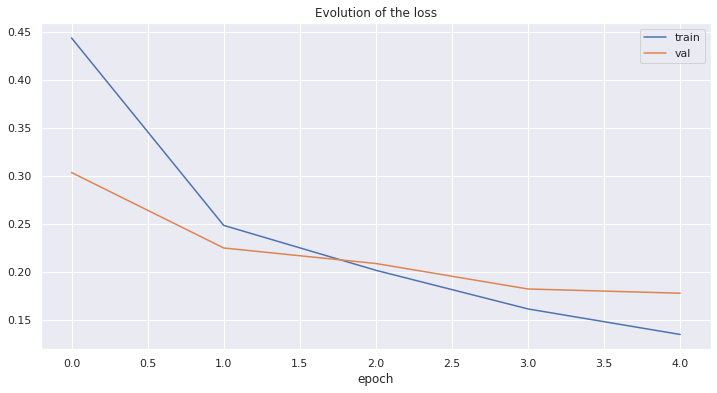

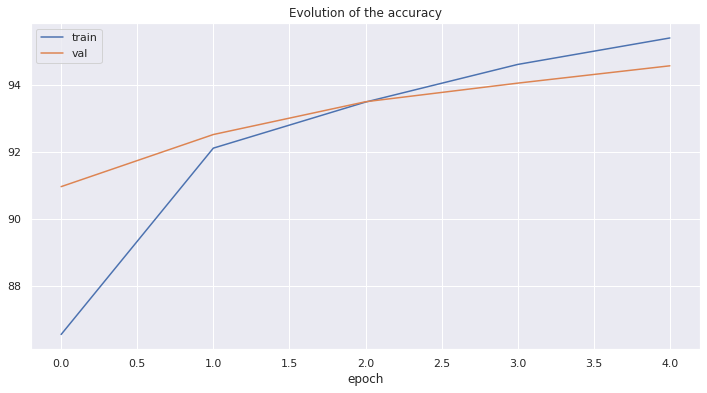

In [0]:
train_loss = train_state['train_loss']
train_acc = train_state['train_acc']
val_loss = train_state['val_loss']
val_acc = train_state['val_acc']

plt.plot(train_loss,label="train")
plt.plot(val_loss,label="val")
plt.legend()
plt.title("Evolution of the loss")
plt.xlabel("epoch")
plt.show()

plt.plot(train_acc,label="train")
plt.plot(val_acc,label="val")
plt.legend()
plt.title("Evolution of the accuracy")
plt.xlabel("epoch")
plt.show()



On calcule l'AUC. 

In [0]:
classifier.eval().cuda()
n_chunks = 8
dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                  batch_size=int(dataset.test_size / n_chunks), 
                                  device=args.device)
y_score = np.array([])
y_test = np.array([])

for batch_dict in batch_generator:
  y_score = np.concatenate((y_score, torch.sigmoid(classifier(batch_dict['x_data'])).cpu().detach().numpy()))
  y_test = np.concatenate((y_test, batch_dict['y_target'].cpu().detach().numpy()))

#y_test = batch_dict['y_target'].cpu().detach().numpy()
print(y_score[:20])
y_pred_test = np.zeros(len(y_score))
y_pred_test[y_score > 0.5] = 1.0
print(metrics.classification_report(y_test, y_pred_test))
auc = roc_auc_score(y_test, y_score)
print("Test F1 score: ", f1_score(y_test, y_pred_test))
print("ROC-AUC: ", auc)

[2.54511833e-05 3.30200195e-02 1.63940430e-01 1.16149902e-01
 3.85742188e-01 6.84204102e-02 2.39729881e-04 1.65161133e-01
 4.57382202e-03 8.52661133e-02 1.47857666e-02 1.15966797e-02
 6.52465820e-02 1.08215332e-01 7.51876831e-03 3.15551758e-02
 4.13208008e-02 1.30233765e-02 3.33862305e-02 1.54876709e-03]
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     14330
         1.0       0.82      0.56      0.67      1622

    accuracy                           0.94     15952
   macro avg       0.89      0.77      0.82     15952
weighted avg       0.94      0.94      0.94     15952

Test F1 score:  0.6669104204753198
ROC-AUC:  0.9308815544807396


## 12. Inference (qualitative)

Regardons quelques exemples de prédictions

In [0]:
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

In [0]:
def predict_category(comment, classifier, vectorizer, max_length,i=-1):
    """Predict a News category for a new title
    
    Args:
        title (str): a raw title string
        classifier (NewsClassifier): an instance of the trained classifier
        vectorizer (NewsVectorizer): the corresponding vectorizer
        max_length (int): the max sequence length
            Note: CNNs are sensitive to the input data tensor size. 
                  This ensures to keep it the same size as the training data
    """
    comment = preprocess_text(comment)
    vectorized_comment = \
        torch.tensor(vectorizer.vectorize(comment, vector_length=max_length))
    result = classifier(vectorized_comment.unsqueeze(0), apply_sigmoid=True).squeeze()
    
    if i == -1:
      out = result.item()
    else:
      out = result[i].item()
    return {'probability': out}

In [0]:
def get_samples_binary(max_s=5):
    samples = {}
    for cat in dataset.val_df.clean.unique():
        samples[cat] = dataset.val_df.comment_text[dataset.val_df.clean==cat].sample(max_s).tolist()
    return samples

def get_samples_multi(max_s=5):
    labels = []
    samples = {}
    samples["clean"] = dataset.val_df.comment_text[dataset.val_df.clean==True].sample(max_s).tolist()
    samples["identity_hate"] = dataset.val_df.comment_text[dataset.val_df.identity_hate==1].sample(max_s).tolist()
    samples["insult"] = dataset.val_df.comment_text[dataset.val_df.insult==1].sample(max_s).tolist()
    samples["obscene"] = dataset.val_df.comment_text[dataset.val_df.obscene==1].sample(max_s).tolist()
    samples["severe_toxic"] = dataset.val_df.comment_text[dataset.val_df.severe_toxic==1].sample(max_s).tolist()
    samples["threat"] = dataset.val_df.comment_text[dataset.val_df.threat==1].sample(max_s).tolist()
    samples["toxic"] = dataset.val_df.comment_text[dataset.val_df.toxic==1].sample(max_s).tolist()
    return samples


In [0]:

if args.binary:
  val_samples = get_samples_binary(5)
  classifier = classifier.to("cpu")

  for truth, sample_group in val_samples.items():
      print(f"True Category: {truth}")
      print("="*30)
      for sample in sample_group:
          prediction = predict_category(sample, classifier, 
                                        vectorizer, dataset._max_seq_length + 1)
          print("Prediction:(p={:0.2f})".format( prediction['probability']))
          print("\t + Sample: {}".format(sample))
      print("-"*30 + "\n")
else:
  val_samples = get_samples_multi(5)
  classifier = classifier.to("cpu")
  i = 0
  for truth, sample_group in val_samples.items():
      print(f"True Category: {truth}")
      print("="*30)
      for sample in sample_group:
          prediction = predict_category(sample, classifier, 
                                        vectorizer, dataset._max_seq_length + 1,i)
          print("Prediction:(p={:0.2f})".format( prediction['probability']))
          print("\t + Sample: {}".format(sample))
      i += 1
      print("-"*30 + "\n")

True Category: False


RuntimeError: ignored

Below is a biais detector

In [0]:
comment_list = ["white people","black people","I am heterosexual","I am homosexual","I am gay","I am a man","I am a woman"]
classifier = classifier.to("cpu")

if args.binary:
      print("="*30)
      for comment in comment_list:
        prediction = predict_category(comment, classifier, 
                                      vectorizer, dataset._max_seq_length + 1)
        print("Sample : {}".format(comment))
        print("Toxicity:(p={:0.2f})".format( prediction['probability']))
else:
      print("="*30)
      for comment in comment_list:
        print("Sample : {}".format(comment))
        for i in range(7):
          prediction = predict_category(comment, classifier, 
                                            vectorizer, dataset._max_seq_length + 1,i)
          print(prediction['probability'])

In [0]:
comment = input()
classifier = classifier.to("cpu")

if args.binary:
      print("="*30)
      prediction = predict_category(comment, classifier, 
                                    vectorizer, dataset._max_seq_length + 1)
      print("Prediction:(p={:0.2f})".format( prediction['probability']))
else:
      print("="*30)
      for i in range(7):
        prediction = predict_category(comment, classifier, 
                                          vectorizer, dataset._max_seq_length + 1,i)
        print(prediction['probability'])

# 12. Confusion (quantitative)

L'accuracy n'est pas une mesure suffisante dans notre cas, on veut regarder les cas commentaires toxique/non toxique séparemment

In [0]:
def confusion_multi(y_pred, y_target):
    out_dim = y_pred.size(-1)
    M = torch.zeros((out_dim,2,2))
    l = len(y_target)
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu()
    for j in range(out_dim):
      for i in range(l):
        M[j,int(y_target[i][j]),int(y_pred_indices[i][j])] += 1
    return M


def confusion_binary(y_pred, y_target):
    M = torch.zeros((1,2,2))
    l = len(y_target)
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu()
    for i in range(l):
      M[0,int(y_target[i]),int(y_pred_indices[i])] += 1
    return M



In [0]:
classifier.eval().cuda()
dataset.set_split('val')
batch_generator = generate_batches(dataset, 
                                  batch_size=args.batch_size, 
                                  device=args.device)

M = torch.zeros((args.out_dim,2,2))
for batch_index, batch_dict in enumerate(batch_generator):

  y_pred =  classifier(batch_dict['x_data'])
  if args.binary:
    M_t = confusion_binary(y_pred, batch_dict['y_target'])
  else:
    M_t = confusion_multi(y_pred, batch_dict['y_target'])
  M += M_t


In [0]:
for i in range(args.out_dim):
  print(M[i])

# 13. Analyse Rationales 

In [0]:
def generate_rationale(comment, generator, vectorizer, max_length,i=-1):
    """Predict a News category for a new title
    
    Args:
        title (str): a raw title string
        classifier (NewsClassifier): an instance of the trained classifier
        vectorizer (NewsVectorizer): the corresponding vectorizer
        max_length (int): the max sequence length
            Note: CNNs are sensitive to the input data tensor size. 
                  This ensures to keep it the same size as the training data
    """
    comment = preprocess_text(comment)
    vectorized_comment = \
        torch.tensor(vectorizer.vectorize(comment, vector_length=max_length))

    init_hidden = generator.initHidden(1)
    z = generator.sample(vectorized_comment.unsqueeze(0),init_hidden)
    print(z)

In [0]:
if args.binary:
  val_samples = get_samples_binary(5)
  classifier = classifier.to("cpu")
  generator = generator.to("cpu")

  for truth, sample_group in val_samples.items():
      print(f"True Category: {truth}")
      print("="*30)
      for sample in sample_group:
          #prediction = predict_category(sample, classifier, 
                                        #vectorizer, dataset._max_seq_length + 1)
          prediction = generate_rationale(sample, generator, 
                                        vectorizer, dataset._max_seq_length + 1)
          print("\t + Sample: {}".format(sample))
      print("-"*30 + "\n")

# 14. Results

Binary output :

id | Model used | Embeddings | epochs | dropout | batch size | learning rate | hidden_size | num_channels| kernel size | max length | level | accuracy | loss
--- | --- | --- | ---| --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
1 | MLP1 | 50 | 20 | 0.15 | 128 | 0.001 |  50 | - | - | 800 | words | 87 % | 0.42 
2 | MLP1 | G50 | 20 | 0.25 | 128 | 0.002 |  50 | - | - | 800 | words | 89 % | 0.3
3 | CNN1 | 50 | 2 | 0.25 | 128 | 0.002 |  50 | 64 | 3 | 800 | words | 91% | 0.254 
4 | CNN1 | G50 | 5 | 0.25 | 128 | 0.002 |  50 | 64 | 3 | 800 | words | 91% | 0.28
5 | GRU1 | 50 | 4 | 0.25 | 128 | 0.002 |  50 | 64 | 3 | 800 | words | 92.4% | 0.204
6 | GRU1 | G50 | 4 | 0.25 | 128 | 0.002 |  50 | 64 | 3 | 800 | words | 93% | 0.19
7 | GRU2 | 50 | 5 | 0.25 | 128 | 0.002 |  50 | - | - | 800 | words | 90 % | 0.28
8 | GRU2 | G50 | 5 | 0.25 | 128 | 0.002 |  50 | - | - | 800 | words | 92 % | 0.23
9 | GRU2 | 25 | 8 | 0.25 | 128 | 0.0005 |  50 | - | - | 2000 | char | 90 % | 0.31


le CNN overfit à balle

On note également que les embeddings entrainé sur ce dataset sont TRES biaisé (black/white, gay, etc...) alors que Glove bcp moins !

Multilabel :


id | epochs | clean | unclean | hate | insult | obscene | severe toxic | threat  |  toxic
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- 
1 | 20 | 84 % |  86 % | 1.3 % | 60 % |  65 % | 12 % |0  % | 83%
2 | 20 | 83 % | 87% | 0.6 % | 53 % | 55 % | 5% | 0% | 85 %
3 | 2 | 89 % | 83 % | 0% | 67% | 78% | 8% | 0% | 81% 
3 | 4 | 86 % | 91 % | 0% | 67% | 77% | 10% | 0% | 90% 
4 | 5 | 89 % | 94 % | 0% | 73% | 81% | 7 % | 0% | 94 % 
5 | 5 | 88 % | 93 % | 0% | 58% | 71% | 9 % | 0% | 89 % 
5 | 6 | 91 % | 89 % | 0% | 72% | 73% | 19 % | 0% | 88 % 
6 | 5 | 90 % | 95 % | 0% | 75% | 87% | 50 % | 0% | 86 % 
7 | 5 | 90 % | 90 % | 1.7% | 67% | 77% | 20 % | 1% | 89 % 
8 | 4 | 92 % | 94 % | 10% | 77% | 84% | 28 % | 0% | 92 % 
